In this project, I want to answer some business questions based on AIRBNB data provided through Kaggle. I focused my interest to Seattle data specifically. I start with importing some libraries(the usual suspects)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import numpy as np
from collections import defaultdict

%matplotlib inline

In [3]:
#This part is for setting some standars of viewing in my notebook.
pd.set_option('display.max_columns',500) 
#pd.set_option('display.max_rows', 25) # pandas to show rows
plt.rcParams['figure.figsize'] = [20, 10] # matplotlib plot size

In [10]:
calendar = pd.read_csv('./calendar.csv')
calendar.head(20)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN
5,241032,2016-01-09,f,NaN
6,241032,2016-01-10,f,NaN
7,241032,2016-01-11,f,NaN
8,241032,2016-01-12,f,NaN
9,241032,2016-01-13,t,$85.00


In [5]:
listings = pd.read_csv('./listings.csv')
listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48


In [6]:
reviews = pd.read_csv('./reviews.csv')
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


First question I would like to find out is when do hosts tend to increase their prices. In order to do so, I am going to note down the dates where each listing is priced at its peak. I will then add up the number of times a date is listed as a maximum priced day for a single listing. The date with most "maximum priced" count will be the maximum priced date of the year. 

In order to do the calculations, I will be using the calendar dataset. Let's start by looking at the data to determine the necessary cleaning it requires.

In [12]:
calendar.dtypes

listing_id     int64
date          object
available     object
price         object
dtype: object

I need to convert the price to an integer and would like to work on date as a date type. Following functions will ensure those data type conversions:

In [13]:
def price_type_converter(df):
    df['price']=df['price'].replace('[\$,]','',regex=True).astype(float)
    return df

In [14]:
def date_type_converter(df):
    df['date']=pd.to_datetime(df['date'],format='%Y-%m-%d', errors='ignore')
    return df

In [15]:
calendar = price_type_converter(calendar)

In [16]:
calendar = date_type_converter(calendar)

In [17]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null datetime64[ns]
available     1393570 non-null object
price         934542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 42.5+ MB


In [ ]:
`#count=0
#for listing in calendar['listing_id'].unique():
#    count = count + 1
#    print(listing)
#    if count<3:
#        x = calendar[calendar['listing_id']== listing]['date']
#        y = calendar[calendar['listing_id']== listing]['price']
#        plt.plot(x,y)
#    else:
#        break
#

It is time to extract the maximum priced days of each listing. I will create a Series called dates where I will append maximum priced nights from each listing.

In [22]:
dates=pd.Series()
for listing in calendar['listing_id'].unique():
    maximum_price = calendar[calendar['listing_id'] == listing]['price'].max()
    temp_df=calendar[calendar['listing_id']==listing]
    dates_temp=temp_df.loc[temp_df['price']== maximum_price]['date']
    dates = dates.append(dates_temp)
    #if count<10:
    #    print(listing)
    #    x = calendar[calendar['listing_id']== listing]['date']
    #    y = calendar[calendar['listing_id']== listing]['price']
    #    plt.plot(x,y)
    #    count+=1
    #else:
    #    break

Next step is counting the appearance of each date in the series so that we will see when hosts hike up their prices the most. 

In [29]:
dates_counts=dates.value_counts()
dates_counts.head(15)

2016-12-31    2102
2016-12-30    2094
2016-12-24    2078
2016-12-23    2074
2016-08-27    2058
2016-08-26    2054
2016-09-03    2051
2016-12-17    2050
2016-09-02    2048
2016-12-16    2047
2016-06-25    2034
2016-12-10    2033
2016-12-09    2032
2016-08-20    2024
2016-06-24    2024
dtype: int64

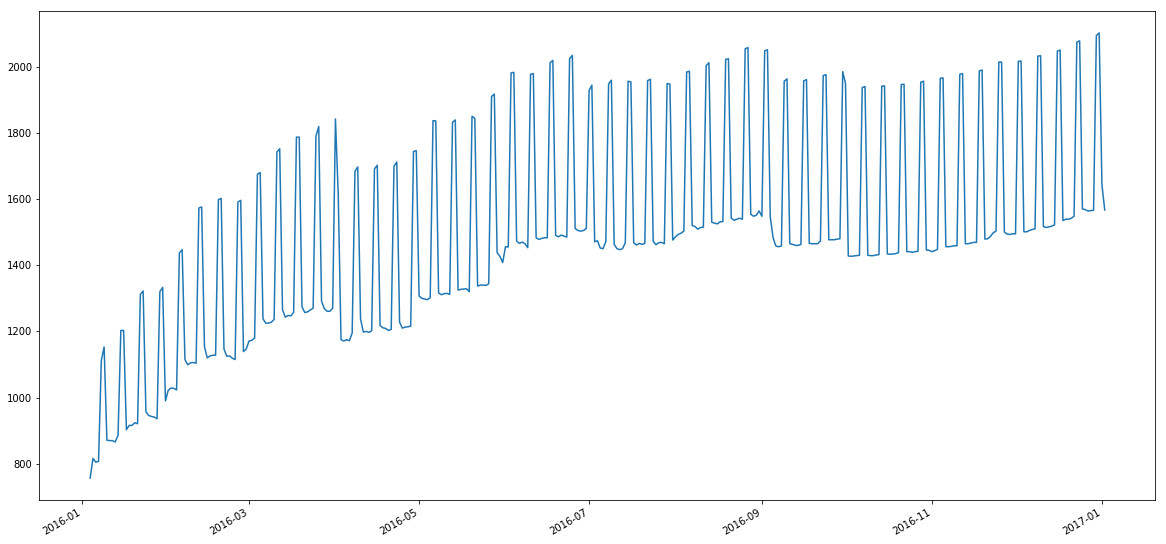

In [28]:
dates_counts.plot()

##### Looking at the plot and the values above, we can derive couple conclusions.

1- Most number of listings had their highest prices at the 30th and 31sh of December.

2- This is followed by the weekend before Christmas. Surprisingly the sunday before the Christmas was not hiked although it is holiday the day after.

3- The pattern of price drops from Sunday through Thursday can be easily observed as expected.

4- Hosts tend to hike up their prices during the holiday season. There is a clear pattern for more and more number of places coming up with their maximum price as we reach the end of the year. 

5- First three months of the year shows the dates with minimum number of maximum priced dates. 

##### It is important to note that
This analysis may be biased if some locations are only being listed on the dates with high prices. In order to understand the data better, I would like to ask 2 more questions.

#### When does Seattle has the most expensive night to stay?

I would like to plot the average cost of stay in Seattle throughout the year.

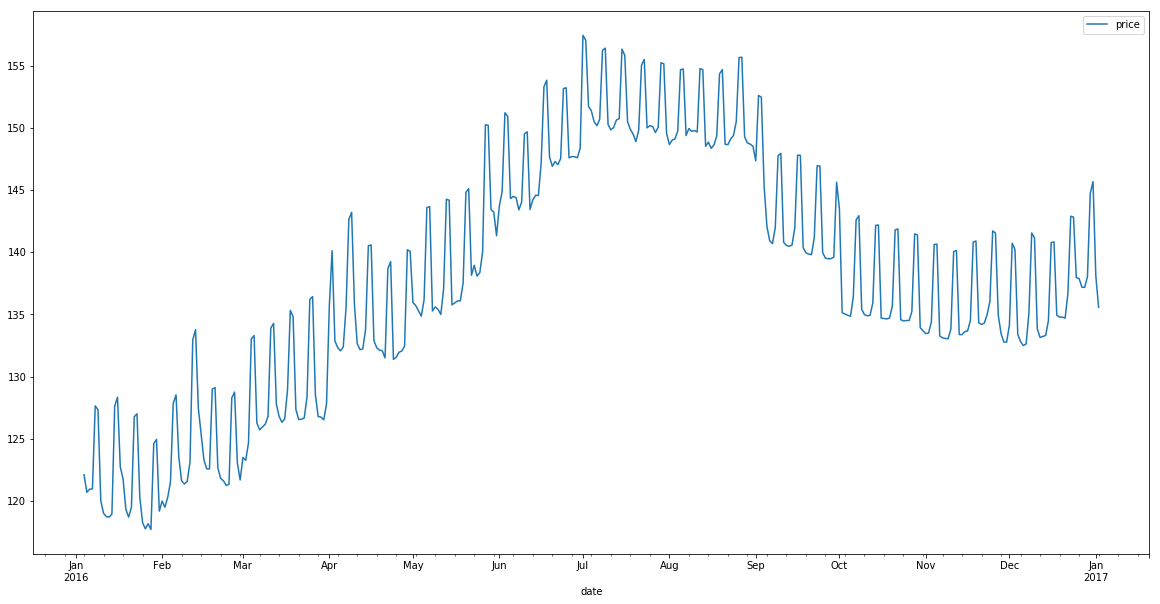

In [56]:
averages = pd.DataFrame( columns=['date','price'])
for date in calendar['date'].unique():
    average_price = calendar[calendar['date'] == date]['price'].mean()
    averages = averages.append({'date':date,'price':average_price}, ignore_index=True)
averages.plot(x='date',y='price')

#### When does Seattle have the most number of listings throughout the year? Can we estimate the seasons of Seattle based on this?

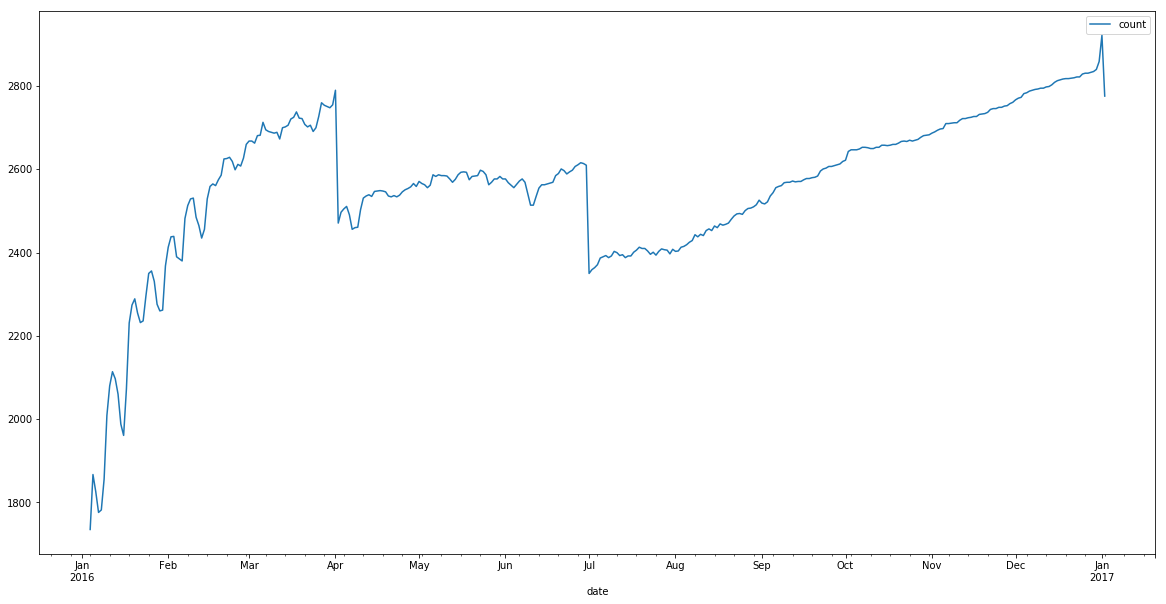

In [75]:
deneme = pd.DataFrame( columns=['date','count'])
available_calendar = calendar[calendar['available'] == 't']
for date in calendar['date'].unique():
    available=available_calendar[available_calendar['date'] == date].shape[0]
    deneme = deneme.append({'date':date,'count':available}, ignore_index=True)
deneme.plot(x='date',y='count')

#### Can we come up with a basic price estimate for Seattle?